# How to choose spatial pixel size for a given PSF?


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
from gammapy.utils.gauss import Gauss2DPDF
from gammapy.maps import MapAxis

In [3]:
def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1) + 2

def get_binsz(k_max, n):
    """Get bin size
        
    Parameters
    ----------
    k_max : float
        Max spatial frequency
    n : int
        Sample size
    """
    return 0.5 * (n - 1) / (k_max * n)



In [4]:
sigma = 0.1
containment = 1 - 1e-5

gauss_psf = Gauss2DPDF(sigma)
sigma_max = 5 * sigma #gauss_psf.containment_radius(containment)

binsz_desired = 0.02

n = round_up_to_odd(2 * sigma_max / binsz_desired)
x = np.linspace(-sigma_max, sigma_max, n)
y = np.linspace(-sigma_max, sigma_max, n)[:, np.newaxis]
binsz = np.mean(np.diff(x))

Text(0, 0.5, 'y [deg]')

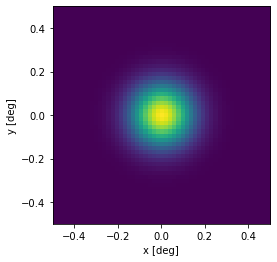

In [5]:
z = gauss_psf(x, y)
plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()])
plt.xlabel("x [deg]")
plt.ylabel("y [deg]")

In [6]:
spectrum =  2 * np.pi * (sigma * binsz) ** 2 * np.abs(np.fft.fft2(z))

k_x = np.fft.fftfreq(len(x), d=binsz)
k_y = np.fft.fftfreq(len(y), d=binsz)

idx_x = np.argsort(k_x)
idx_y = np.argsort(k_y)[:, np.newaxis]
k_x = k_x[idx_x]
k_y = k_y[idx_y]

spectrum = spectrum[idx_y, idx_x]

Text(0, 0.5, 'k_y [1/deg]')

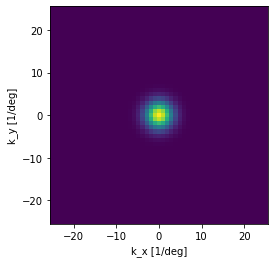

In [7]:
plt.imshow(np.sqrt(spectrum), extent=[k_x.min(), k_x.max(), k_y.min(), k_y.max()])
plt.xlabel("k_x [1/deg]")
plt.ylabel("k_y [1/deg]")

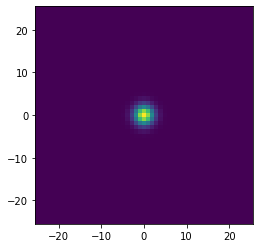

In [8]:
gauss_psf_k = Gauss2DPDF(sigma=1 / (2 * np.pi * sigma))
plt.imshow(gauss_psf_k(k_x, k_y), extent=[k_x.min(), k_x.max(), k_y.min(), k_y.max()])

In [9]:
k_max = gauss_psf_k.containment_radius(containment)

In [10]:
get_binsz(k_max, len(x))

0.06423467074906504

We first define a Gaussian function:

In [11]:
def gauss(x, sigma=0.1):
    norm = 1 / np.sqrt(2 * np.pi * sigma ** 2)
    return norm * np.exp(- 0.5 * (x  / sigma) ** 2)

def gauss_tilde(k, sigma=0.1):
    return np.exp(- 0.5 * (2 * np.pi * k * sigma) ** 2)

def box(x, width=0.01):
    condition = (x > -width) & (x > width) 
    return np.where(condition, 1, 0)

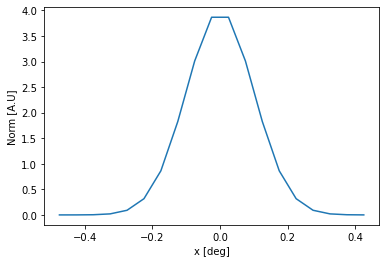

In [12]:
sample_size = 0.05
sigma = 0.1
x_edges = np.arange(-5 * sigma, 5 * sigma, sample_size)
x = (x_edges[1:] + x_edges[:-1]) / 2
y = norm.pdf(x, scale=sigma)

plt.plot(x, y)
plt.xlabel("x [deg]")
plt.ylabel("Norm [A.U]");

In [13]:
spectrum = np.sqrt(2 * np.pi) * sigma * sample_size * np.abs(np.fft.fft(y))

n = spectrum.size
k = np.fft.fftfreq(n, d=sample_size)
idx = np.argsort(k)
k, spectrum = k[idx], spectrum[idx]

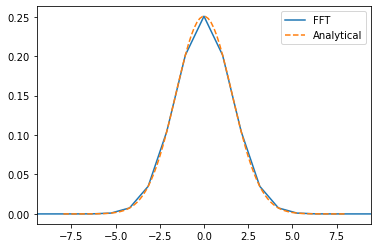

In [14]:
plt.plot(k, spectrum, label="FFT")

sigma_k = 1 / (2 * np.pi * sigma)

k_fine = np.linspace(-5 * sigma_k, 5 * sigma_k, 100)
plt.plot(k_fine, norm.pdf(k_fine, scale=sigma_k), ls="--", label="Analytical")
plt.legend()
plt.xlim(k.min(), k.max());

In [15]:
c = 1 - 2 * norm.sf(5)

In [16]:
k_max = norm.isf((1 - c) / 2, scale=sigma_k)

In [17]:
get_binsz(k_max, n=100)

0.062203534540984436

In [18]:
norm.cdf(5, scale=sigma_k)

0.9991598418317367

In [19]:
from scipy.stats import rv_histogram

In [20]:
k = np.sort((np.fft.fftfreq(n + 1, d=sample_size) + 0.5))
spec_pdf = rv_histogram((spectrum, k))

In [21]:
k_max = max(spec_pdf.interval(0.999999))

In [22]:
get_binsz(k_max, len(spectrum))

0.05495721342425869